# Features engineering for NDVI trends prediction

## Overview

- **Key ideas:**
    - **Computation:** Intensive calculations that require a lot of RAM memory, so run this notebook in aerossol server.
    - **Target and raw features:** Engineer physical features for each grid point in South America in order to predict NDVI long term monotonic trends (decadal variation) using some machine learning model. More precisely, the initial features obtained here are the following: 
        - (01) `LAT` Latitude; 
        - (02) `LON` Longitude; 
        - (03) `ELEV` Elevation; 
        - (04) `LC` Land class for 2015;
        - (05) `LC` Counts of annual land class changes from 2001 until 2015;
        - (06) `P` Mean precipitation;
        - (07) `P` Standard deviation of precipitation;
        - (08) `P` Long term trends of precipitation;
        - (09) `TMAX` Mean maximum 2-m temperature;
        - (10) `TMAX`Standard deviation of maximum 2-m temperature;
        - (11) `TMAX`Long term trends of maximum 2-m temperature;
        - (12) `TMIN` Mean minimum 2-m temperature;
        - (13) `TMIN` Standard deviation of minimum 2-m temperature;
        - (14) `TMIN` Long term trends of minimum 2-m temperature;
        - (15) `SRAD` Mean downward shortwave radiation flux at the surface;
        - (16) `SRAD` Standard deviation of downward shortwave radiation flux at the surface;
        - (17) `SRAD` Long term trends of downward shortwave radiation flux at the surface;
        - (18) `PDSI` Mean Palmer drought severity index;
        - (19) `PDSI` Standard deviation of Palmer drought severity index;
        - (20) `PDSI` Long term trends of Palmer drought severity index;
        - (21) `NDVI` Mean NDVI;
        - (22) `NDVI` Standard deviation of NDVI.
        - (23) `PAS` Protected areas.
        - (24) `BIO` Biomes.
    - **Export data matrix:**  Put all those features along with target in a pandas DataFrame object and export it as a csv file.  
    - **Exploratory data analysis:** Unveil relations between these features and target: (1) NDVI trend by land class in 2015 and land class annual variations over 2001 - 2015 period and (2) bi-histograms for remaining features versus target.
    - **Preprocessing of raw features**: (1) One hot encoding for the two categorical features, namely land class for each pixel in 2015 and whether the grid point belongs to a protected area or not, (2) robust scaling of all data, including the one-hot-encoded features, (3) linear dimensionality reduction by means of PCA, and (4) Yeo-Johnson power transform to principal components in order to make the resulting data distribution more Gaussian.
    - **Preprocessing evaluation:** Quick performance comparison between a SVM model trained on raw features (just with one hot encoding) and a SVM model having as input   the preprocessed features as explained above.  
- **Notes:**  
    - For tree-based models, which are the one we normally use the most, it is not necessary to scale data, but we do it here just for didactic purposes.
    - Since each instance (a row in data matrix) represents a pixel, there is no need to train a model along time axis. However, spatial autocorrelation still might be a problem when training and evaluating models.

## Initial setup

In [1]:
%%time

# Load packages.
import os
import sys
import warnings
import scipy

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KernelDensity
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Better visualization.
xr.set_options(display_style="text")

warnings.filterwarnings("ignore")
%matplotlib inline

CPU times: user 1.37 s, sys: 288 ms, total: 1.66 s
Wall time: 2.42 s


In [2]:
print(">>> Versions:")
print("* numpy:", np.__version__)
print("* pandas:", pd.__version__)
print("* xarray:", xr.__version__)
print("\n>>> Computer:")
!echo "* Hostname: ${HOSTNAME}"
!echo "* User: ${USER}"
!echo "* Directory: $(pwd)"
!echo "* Date: $(date)"
!echo "* CPUs: $(nproc)"

>>> Versions:
* numpy: 1.19.1
* pandas: 1.1.1
* xarray: 0.16.0

>>> Computer:
* Hostname: n007
* User: sandroal
* Directory: /work/sandroal/notebooks/modelling
* Date: Wed Dec 16 11:57:58 BRST 2020
* CPUs: 40


In [3]:
%%time

# My repository.
repository = "/work/sandroal/cdlearn/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

CPU times: user 1.66 s, sys: 404 ms, total: 2.06 s
Wall time: 3.07 s


In [4]:
# Where figures will be put.
FIG_FOLDER = "/work/sandroal/images/modelling/"

# Final results.
save_fig = True

# South America.
loni, lonf, lati, latf = -90, -30, -60, 20

# Decadal variation in 15-day time step trends.
factor = 120 * 2

# Significance global threshold (decadal variation).
u = 0.0192

## NDVI

In [5]:
%%time

# Into memory.
DS_NDVI = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/GIMMS/ppdata_ndvi.nc"
).load()

# Only land pixels.
DS_NDVI = DS_NDVI.where(DS_NDVI.land_mask==True, drop=True)

# Show it.
print(DS_NDVI)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666, time: 828)
Coordinates:
    land_mask  (lat, lon) bool False False False False ... False False False
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * time       (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
Data variables:
    ndvi       (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolu

In [6]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/GIMMS/ppdata_ndvi_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_NDVI_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_NDVI, var_code="ndvi", verbose=True
    )
    
    # Export preprocessed data.
    DS_NDVI_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_NDVI_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_NDVI_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 86.3 ms


## Elevation

In [7]:
%%time

# Into memory.
DS_ELEV = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/GLOBE/ppdata_elevation.nc"
).load()

# Land pixels.
DS_ELEV = DS_ELEV.where(DS_ELEV.land_mask==True, drop=True)

# Show it.
print(DS_ELEV)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666)
Coordinates:
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
    land_mask  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    elevation  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    regrid_method:  bilinear
CPU times: user 32 ms, sys: 12 ms, total: 44 ms
Wall time: 107 ms


## Land cover

In [8]:
%%time

# Into memory.
DS_LC_ANU = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/MODIS/LAND_COVER/" + \
                    "ppdata_land_cover_008x008_2001_2019_south_america.nc"
).load()

# Land pixels.
DS_LC_ANU = DS_LC_ANU.where(DS_LC_ANU.land_mask==True, drop=True)

# Add a new class: Water class for sea (-1), different of water class in land (0).
DS_LC_ANU = DS_LC_ANU.where(DS_LC_ANU.land_mask==True, other=-1)

# Show it.
print(DS_LC_ANU)

<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666, time: 19)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * time        (time) datetime64[ns] 2001-01-01 2002-01-01 ... 2019-01-01
Data variables:
    land_class  (time, lat, lon) float64 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0
CPU times: user 164 ms, sys: 140 ms, total: 304 ms
Wall time: 535 ms


In [9]:
# All land types.
classes_dict_swapped = {
    "Water":                               0,
    "Evergreen needleleaf forest":         1,
    "Evergreen broadleaf forest":          2,
    "Deciduous needleleaf forest":         3,
    "Deciduous broadleaf forest":          4,
    "Mixed forests":                       5,
    "Closed shrubland":                    6,
    "Open shrublands":                     7,
    "Woody savannas":                      8,
    "Savannas":                            9,
    "Grasslands":                          10,
    "Permanent wetlands":                  11,
    "Croplands":                           12,
    "Urban and built up":                  13,
    "Cropland natural vegetation mosaic":  14,
    "Snow and ice":                        15,
    "Barren or sparsely vegetated":        16
}  

# Swap keys and values of the previous dict.
classes_dict = dict([(value, key) for key, value in classes_dict_swapped.items()]) 

## Precipitation

In [10]:
%%time

# Into memory.
DS_P = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/CHIRPS/ppdata_precipitation.nc"
).load()

# Land pixels.
DS_P = DS_P.where(DS_P.land_mask==True, drop=True)

# Show it.
print(DS_P)

<xarray.Dataset>
Dimensions:        (lat: 912, lon: 666, time: 828)
Coordinates:
  * time           (time) datetime64[ns] 1981-07-01 1981-07-15 ... 2015-12-15
  * lon            (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
  * lat            (lat) float64 -55.96 -55.88 -55.79 ... 19.79 19.88 19.96
    land_mask      (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    creator_email:     pete@geog.ucsb.edu
    institution:       Climate Hazards Group.  University of California at Sa...
    documentation:     http://pubs.usgs.gov/ds/832/
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    com

In [11]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/CHIRPS/ppdata_precipitation_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_P_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_P, var_code="precipitation", verbose=True
    )
    
    # Export preprocessed data.
    DS_P_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_P_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_P_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 85 ms


## Maximum 2-m temperature

In [12]:
%%time

# Into memory.
DS_TMAX = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/TERRACLIMATE/ppdata_tmax.nc"
).load()

# Only land pixels.
DS_TMAX = DS_TMAX.where(DS_TMAX.land_mask==True, drop=True)

# Show it.
print(DS_TMAX)

<xarray.Dataset>
Dimensions:            (lat: 912, lon: 666, time: 414)
Coordinates:
  * time               (time) datetime64[ns] 1981-07-01 ... 2015-12-01
  * lon                (lon) float64 -89.96 -89.88 -89.79 ... -32.46 -32.38
  * lat                (lat) float64 -55.96 -55.88 -55.79 ... 19.79 19.88 19.96
    land_mask          (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    tmax               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    station_influence  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    method:         These layers from TerraClimate were creating using climat...
    regrid_method:  bilinear
CPU times: user 5.26 s, sys: 5.74 s, total: 11 s
Wall time: 18.4 s


In [13]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/TERRACLIMATE/ppdata_tmax_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_TMAX_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_TMAX, var_code="tmax", verbose=True
    )
    
    # Export preprocessed data.
    DS_TMAX_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_TMAX_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_TMAX_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 82.2 ms


## Minimum 2-m temperature

In [14]:
%%time

# Into memory.
DS_TMIN = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/TERRACLIMATE/ppdata_tmin.nc"
).load()

# Only land pixels.
DS_TMIN = DS_TMIN.where(DS_TMIN.land_mask==True, drop=True)

# Show it.
print(DS_TMIN)

<xarray.Dataset>
Dimensions:            (lat: 912, lon: 666, time: 414)
Coordinates:
  * time               (time) datetime64[ns] 1981-07-01 ... 2015-12-01
  * lon                (lon) float64 -89.96 -89.88 -89.79 ... -32.46 -32.38
  * lat                (lat) float64 -55.96 -55.88 -55.79 ... 19.79 19.88 19.96
    land_mask          (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Data variables:
    tmin               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    station_influence  (time, lat, lon) float64 nan nan nan nan ... nan nan nan
Attributes:
    method:         These layers from TerraClimate were creating using climat...
    regrid_method:  bilinear
CPU times: user 4.85 s, sys: 6.08 s, total: 10.9 s
Wall time: 18.5 s


In [15]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/TERRACLIMATE/ppdata_tmin_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_TMIN_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_TMIN, var_code="tmin", verbose=True
    )
    
    # Export preprocessed data.
    DS_TMIN_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_TMIN_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_TMIN_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 8 ms, sys: 8 ms, total: 16 ms
Wall time: 78.6 ms


## Downward shortwave radiation flux at the surface

In [16]:
%%time

# Into memory.
DS_SRAD = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/TERRACLIMATE/ppdata_srad.nc"
).load()

# Only land pixels.
DS_SRAD = DS_SRAD.where(DS_SRAD.land_mask==True, drop=True)

# Show it.
print(DS_SRAD)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666, time: 414)
Coordinates:
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
    land_mask  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    srad       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    method:         These layers from TerraClimate were creating using climat...
    regrid_method:  bilinear
CPU times: user 2.25 s, sys: 2.53 s, total: 4.78 s
Wall time: 8.58 s


In [17]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/TERRACLIMATE/ppdata_srad_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_SRAD_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_SRAD, var_code="srad", verbose=True
    )
    
    # Export preprocessed data.
    DS_SRAD_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_SRAD_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_SRAD_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 81.9 ms


## Palmer drought severity index

In [18]:
%%time

# Into memory.
DS_PDSI = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/TERRACLIMATE/ppdata_PDSI.nc"
).load()

# Only land pixels.
DS_PDSI = DS_PDSI.where(DS_PDSI.land_mask==True, drop=True)

# Show it.
print(DS_PDSI)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666, time: 414)
Coordinates:
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
    land_mask  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    PDSI       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    method:         These layers from TerraClimate were creating using climat...
    regrid_method:  bilinear
CPU times: user 2.37 s, sys: 2.89 s, total: 5.26 s
Wall time: 8.96 s


In [19]:
%%time

# Preprocessed file path.
ppdata_fp = "/work/sandroal/data_sets/TERRACLIMATE/ppdata_PDSI_linear_trend_ts.nc" 

# Do it if only necessary.
if not os.path.exists(ppdata_fp):

    # Linear trends.
    DS_PDSI_TRENDS = cdlearn.statistics.theil_slopes(
        data_set=DS_PDSI, var_code="PDSI", verbose=True
    )
    
    # Export preprocessed data.
    DS_PDSI_TRENDS.to_netcdf(path=ppdata_fp, mode="w")  
    
# Load the results if they already exist.
else:
    DS_PDSI_TRENDS = xr.open_dataset(ppdata_fp).load()    

# Show it.
print()
print(DS_PDSI_TRENDS)


<xarray.Dataset>
Dimensions:     (lat: 912, lon: 666)
Coordinates:
  * lat         (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask   (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    slopes      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    intercepts  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 12 ms, sys: 8 ms, total: 20 ms
Wall time: 88.2 ms


## Protected areas

In [20]:
%%time

# Into memory.
DS_PAS = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets//PROTECTED_AREAS/ppdata_polygons_and_points.nc"
).load()

# Only land pixels.
DS_PAS = DS_PAS.where(DS_PAS.land_mask==True, drop=True)

# Show it.
print(DS_PAS)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666)
Coordinates:
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    protected  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 83.6 ms


## Biomes

In [21]:
%%time

# Into memory.
DS_BIO = xr.open_dataset(
    filename_or_obj="/work/sandroal/data_sets/TEOW_WWF/ppdata_biomes.nc"
).load()

# Only land pixels.
DS_BIO = DS_BIO.where(DS_BIO.land_mask==True, drop=True)

# Show it.
print(DS_BIO)

<xarray.Dataset>
Dimensions:    (lat: 912, lon: 666)
Coordinates:
  * lat        (lat) float64 -55.96 -55.88 -55.79 -55.71 ... 19.79 19.88 19.96
  * lon        (lon) float64 -89.96 -89.88 -89.79 ... -33.88 -32.46 -32.38
    land_mask  (lat, lon) int8 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    biome      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  0: Unclassified; 1: Tropical and Subtropical Moist Broadlea...
CPU times: user 36 ms, sys: 12 ms, total: 48 ms
Wall time: 104 ms


## Individual preprocessing of variables

### (0) Target

In [22]:
# Target variable (NDVI trends) as a pandas DataFrame object.
df_target = DS_NDVI_TRENDS.slopes.to_dataframe().reset_index()
df_target = df_target.dropna(axis="index") # Drop sea grid points.
df_target = df_target.drop(labels="land_mask", axis=1) # Drop land mask coordinate.
df_target["slopes"] = factor * df_target["slopes"] # Decadal variation.
df_target.rename({"slopes": "ndvi_slope"}, axis=1, inplace=True)
df_target.reset_index(drop=True, inplace=True) # Index as natural count beginning in 0.

# Show it.
print(">>> Data shape:", df_target.shape)
print(">>> Data head:")
df_target.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,ndvi_slope
0,-55.958333,-67.291667,0.000000
1,-55.875000,-67.958333,0.000000
2,-55.875000,-67.875000,0.000000
3,-55.875000,-67.791667,-0.006285
4,-55.875000,-67.708333,-0.011226


### (3) Elevation

In [23]:
# Elevation.
df_elev = DS_ELEV.elevation.\
                  to_dataframe().\
                  reset_index().\
                  dropna(axis="index").\
                  drop("land_mask", axis=1).\
                  reset_index(drop=True).\
                  rename({"elevation": "elev"}, axis=1) 

# Show it.
print(">>> Data shape:", df_elev.shape)
print(">>> Data head:")
df_elev.head()

>>> Data shape: (229029, 3)
>>> Data head:


,lat,lon,elev
0,-55.875000,-67.541667,107.743539
1,-55.875000,-67.208333,26.987129
2,-55.875000,-67.125000,188.500253
3,-55.791667,-67.208333,160.261995
4,-55.708333,-67.458333,194.751892


### (4) Land class for 2015

In [24]:
# Land class ocurrence in 2015.
df_lc_2015 = DS_LC_ANU.land_class.sel(time="2015").to_dataframe().reset_index()
df_lc_2015 = df_lc_2015[df_lc_2015.land_class != -1].\
             reset_index(drop=True).\
             drop(labels=["time", "land_mask"], axis=1).\
             rename({"land_class": "lclass_2015"}, axis=1)
df_lc_2015["lclass_2015"] = df_lc_2015.lclass_2015.astype(int)

# Show it.
print(">>> Data shape:", df_lc_2015.shape)
print(">>> Data head:")
df_lc_2015.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,lclass_2015
0,-55.958333,-67.291667,0
1,-55.875000,-67.958333,0
2,-55.875000,-67.875000,0
3,-55.875000,-67.791667,0
4,-55.875000,-67.708333,0


### (5) Counts of annual land class changes from 2001 until 2015

In [25]:
# Count number of changing classes for each pixel from 2001 to 2015.
df_lc_2001_2015_dcount = DS_LC_ANU.land_class.sel(time=slice("2001", "2015")).\
                                   diff(dim="time").\
                                   astype(bool).\
                                   sum(dim="time").\
                                   to_dataframe().\
                                   reset_index()
df_lc_2001_2015_dcount = df_lc_2001_2015_dcount[df_lc_2001_2015_dcount.land_mask==1].\
                         reset_index(drop=True).\
                         drop("land_mask", axis=1).\
                         rename({"land_class": "lclass_2001_2015_dcount"}, axis=1)

# Not strictly necessary now.
df_lc_2001_2015_dcount["lclass_2001_2015_dcount"] = \
    df_lc_2001_2015_dcount.lclass_2001_2015_dcount.astype(int)


# Show it.
print(">>> Data shape:", df_lc_2001_2015_dcount.shape)
print(">>> Data head:")
df_lc_2001_2015_dcount.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,lclass_2001_2015_dcount
0,-55.958333,-67.291667,0
1,-55.875000,-67.958333,0
2,-55.875000,-67.875000,0
3,-55.875000,-67.791667,0
4,-55.875000,-67.708333,0


### (6) Mean precipitation

In [26]:
# Mean of precipitation.
df_p_mean = DS_P.precipitation.mean("time").\
                to_dataframe().\
                reset_index().\
                dropna(axis="index").\
                drop("land_mask", axis=1).\
                reset_index(drop=True).\
                rename({"precipitation": "p_mean"}, axis=1)

# Show it.
print(">>> Data shape:", df_p_mean.shape)
print(">>> Data head:")
df_p_mean.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,p_mean
0,-55.958333,-67.291667,0.0
1,-55.875000,-67.958333,0.0
2,-55.875000,-67.875000,0.0
3,-55.875000,-67.791667,0.0
4,-55.875000,-67.708333,0.0


### (7) Standard deviation of precipitation

In [27]:
# Standard deviation of precipitation.
df_p_std = DS_P.precipitation.std("time").\
                to_dataframe().\
                reset_index().\
                dropna(axis="index").\
                drop("land_mask", axis=1).\
                reset_index(drop=True).\
                rename({"precipitation": "p_std"}, axis=1)

# Show it.
print(">>> Data shape:", df_p_std.shape)
print(">>> Data head:")
df_p_std.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,p_std
0,-55.958333,-67.291667,0.0
1,-55.875000,-67.958333,0.0
2,-55.875000,-67.875000,0.0
3,-55.875000,-67.791667,0.0
4,-55.875000,-67.708333,0.0


### (8) Long term trends of precipitation

In [28]:
# Decadal variation of precipitation.
df_p_trends = DS_P_TRENDS.slopes.\
                          to_dataframe().\
                          reset_index().\
                          dropna(axis="index").\
                          drop("land_mask", axis=1).\
                          reset_index(drop=True).\
                          rename({"slopes": "p_slope"}, axis=1)
df_p_trends["p_slope"] = factor * df_p_trends["p_slope"] 

# Show it.
print(">>> Data shape:", df_p_trends.shape)
print(">>> Data head:")
df_p_trends.head()

>>> Data shape: (235434, 3)
>>> Data head:


,lat,lon,p_slope
0,-55.958333,-67.291667,0.0
1,-55.875000,-67.958333,0.0
2,-55.875000,-67.875000,0.0
3,-55.875000,-67.791667,0.0
4,-55.875000,-67.708333,0.0


### (9) Mean maximum 2-m temperature

In [29]:
# Mean of maximum surface air temperature.
df_tmax_mean = DS_TMAX.tmax.mean("time").\
                       to_dataframe().\
                       reset_index().\
                       dropna(axis="index").\
                       drop("land_mask", axis="columns").\
                       reset_index(drop=True).\
                       rename({"tmax": "tmax_mean"}, axis="columns")

# Show it.
print(">>> Data shape:", df_tmax_mean.shape)
print(">>> Data head:")
df_tmax_mean.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmax_mean
0,-55.958333,-67.291667,8.571863
1,-55.875000,-67.875000,8.080813
2,-55.875000,-67.708333,8.000395
3,-55.875000,-67.625000,8.012163
4,-55.875000,-67.208333,8.587447


### (10) Standard deviation of maximum 2-m temperature

In [30]:
# Deviation for maximum surface air temperature.
df_tmax_std = DS_TMAX.tmax.std("time").\
                      to_dataframe().\
                      reset_index().\
                      dropna(axis="index").\
                      drop("land_mask", axis="columns").\
                      reset_index(drop=True).\
                      rename({"tmax": "tmax_std"}, axis="columns")

# Show it.
print(">>> Data shape:", df_tmax_std.shape)
print(">>> Data head:")
df_tmax_std.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmax_std
0,-55.958333,-67.291667,2.934586
1,-55.875000,-67.875000,2.658282
2,-55.875000,-67.708333,2.739862
3,-55.875000,-67.625000,2.824896
4,-55.875000,-67.208333,3.013888


### (11) Long term trends of maximum 2-m temperature

In [31]:
# Slopes for maximum surface air temperature.
df_tmax_trends = DS_TMAX_TRENDS.slopes.\
                                to_dataframe().\
                                reset_index().\
                                dropna(axis="index").\
                                drop("land_mask", axis="columns").\
                                reset_index(drop=True).\
                                rename({"slopes": "tmax_slope"}, axis="columns")
df_tmax_trends["tmax_slope"] = factor * df_tmax_trends["tmax_slope"] 

# Show it.
print(">>> Data shape:", df_tmax_trends.shape)
print(">>> Data head:")
df_tmax_trends.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmax_slope
0,-55.958333,-67.291667,-0.256402
1,-55.875000,-67.875000,-0.276922
2,-55.875000,-67.708333,-0.272723
3,-55.875000,-67.625000,-0.251502
4,-55.875000,-67.208333,-0.264986


### (12) Mean minimum 2-m temperature

In [32]:
# Mean of minimum surface air temperature.
df_tmin_mean = DS_TMIN.tmin.mean("time").\
                       to_dataframe().\
                       reset_index().\
                       dropna(axis="index").\
                       drop("land_mask", axis="columns").\
                       reset_index(drop=True).\
                       rename({"tmin": "tmin_mean"}, axis="columns")

# Show it.
print(">>> Data shape:", df_tmin_mean.shape)
print(">>> Data head:")
df_tmin_mean.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmin_mean
0,-55.958333,-67.291667,0.920774
1,-55.875000,-67.875000,2.144115
2,-55.875000,-67.708333,1.603613
3,-55.875000,-67.625000,1.131905
4,-55.875000,-67.208333,0.900852


### (13) Standard deviation of minimum 2-m temperature

In [33]:
# Deviation for minimum surface air temperature.
df_tmin_std = DS_TMIN.tmin.std("time").\
                      to_dataframe().\
                      reset_index().\
                      dropna(axis="index").\
                      drop("land_mask", axis="columns").\
                      reset_index(drop=True).\
                      rename({"tmin": "tmin_std"}, axis="columns")

# Show it.
print(">>> Data shape:", df_tmin_std.shape)
print(">>> Data head:")
df_tmin_std.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmin_std
0,-55.958333,-67.291667,2.139323
1,-55.875000,-67.875000,2.567216
2,-55.875000,-67.708333,2.409975
3,-55.875000,-67.625000,2.217435
4,-55.875000,-67.208333,2.195782


### (14) Long term trends of minimum 2-m temperature

In [34]:
# Slopes for minimum surface air temperature.
df_tmin_trends = DS_TMIN_TRENDS.slopes.\
                                to_dataframe().\
                                reset_index().\
                                dropna(axis="index").\
                                drop("land_mask", axis="columns").\
                                reset_index(drop=True).\
                                rename({"slopes": "tmin_slope"}, axis="columns")
df_tmin_trends["tmin_slope"] = factor * df_tmin_trends["tmin_slope"] 

# Show it.
print(">>> Data shape:", df_tmin_trends.shape)
print(">>> Data head:")
df_tmin_trends.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,tmin_slope
0,-55.958333,-67.291667,0.400028
1,-55.875000,-67.875000,0.417356
2,-55.875000,-67.708333,0.410715
3,-55.875000,-67.625000,0.400000
4,-55.875000,-67.208333,0.399998


### (15) Mean downward shortwave radiation flux at the surface

In [35]:
# Mean of radiation.
df_srad_mean = DS_SRAD.srad.mean("time").\
                       to_dataframe().\
                       reset_index().\
                       dropna(axis="index").\
                       drop("land_mask", axis="columns").\
                       reset_index(drop=True).\
                       rename({"srad": "srad_mean"}, axis="columns")

# Show it.
print(">>> Data shape:", df_srad_mean.shape)
print(">>> Data head:")
df_srad_mean.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,srad_mean
0,-55.958333,-67.291667,95.180557
1,-55.875000,-67.875000,94.948055
2,-55.875000,-67.708333,93.529483
3,-55.875000,-67.625000,92.182944
4,-55.875000,-67.208333,94.502431


### (16) Standard deviation of downward shortwave radiation flux at the surface

In [36]:
# Deviation of radiation.
df_srad_std = DS_SRAD.srad.std("time").\
                      to_dataframe().\
                      reset_index().\
                      dropna(axis="index").\
                      drop("land_mask", axis="columns").\
                      reset_index(drop=True).\
                      rename({"srad": "srad_std"}, axis="columns")

# Show it.
print(">>> Data shape:", df_srad_std.shape)
print(">>> Data head:")
df_srad_std.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,srad_std
0,-55.958333,-67.291667,63.783978
1,-55.875000,-67.875000,63.036305
2,-55.875000,-67.708333,61.921692
3,-55.875000,-67.625000,61.066145
4,-55.875000,-67.208333,62.982034


### (17) Long term trends of downward shortwave radiation flux at the surface

In [37]:
# Slopes for radiation.
df_srad_trends = DS_SRAD_TRENDS.slopes.\
                                to_dataframe().\
                                reset_index().\
                                dropna(axis="index").\
                                drop("land_mask", axis="columns").\
                                reset_index(drop=True).\
                                rename({"slopes": "srad_slope"}, axis="columns")
df_srad_trends["srad_slope"] = factor * df_srad_trends["srad_slope"] 

# Show it.
print(">>> Data shape:", df_srad_trends.shape)
print(">>> Data head:")
df_srad_trends.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,srad_slope
0,-55.958333,-67.291667,-0.000253
1,-55.875000,-67.875000,0.000000
2,-55.875000,-67.708333,0.000000
3,-55.875000,-67.625000,0.000000
4,-55.875000,-67.208333,0.000000


### (18) Mean Palmer drought severity index

In [38]:
# Mean of PDSI.
df_pdsi_mean = DS_PDSI.PDSI.mean("time").\
                       to_dataframe().\
                       reset_index().\
                       dropna(axis="index").\
                       drop("land_mask", axis="columns").\
                       reset_index(drop=True).\
                       rename({"PDSI": "pdsi_mean"}, axis="columns")

# Show it.
print(">>> Data shape:", df_pdsi_mean.shape)
print(">>> Data head:")
df_pdsi_mean.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,pdsi_mean
0,-55.958333,-67.291667,-0.962742
1,-55.875000,-67.875000,-0.950362
2,-55.875000,-67.708333,-0.942631
3,-55.875000,-67.625000,-0.919806
4,-55.875000,-67.208333,-0.984239


### (19) Standard deviation of Palmer drought severity index

In [39]:
# Deviation of PDSI.
df_pdsi_std = DS_PDSI.PDSI.std("time").\
                      to_dataframe().\
                      reset_index().\
                      dropna(axis="index").\
                      drop("land_mask", axis="columns").\
                      reset_index(drop=True).\
                      rename({"PDSI": "pdsi_std"}, axis="columns")

# Show it.
print(">>> Data shape:", df_pdsi_std.shape)
print(">>> Data head:")
df_pdsi_std.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,pdsi_std
0,-55.958333,-67.291667,2.508278
1,-55.875000,-67.875000,2.480082
2,-55.875000,-67.708333,2.458701
3,-55.875000,-67.625000,2.437169
4,-55.875000,-67.208333,2.501392


### (20) Long term trends of Palmer drought severity index

In [40]:
# Slopes for radiation.
df_pdsi_trends = DS_PDSI_TRENDS.slopes.\
                               to_dataframe().\
                               reset_index().\
                               dropna(axis="index").\
                               drop("land_mask", axis="columns").\
                               reset_index(drop=True).\
                               rename({"slopes": "pdsi_slope"}, axis="columns")
df_pdsi_trends["pdsi_slope"] = factor * df_pdsi_trends["pdsi_slope"] 

# Show it.
print(">>> Data shape:", df_pdsi_trends.shape)
print(">>> Data head:")
df_pdsi_trends.head()

>>> Data shape: (230104, 3)
>>> Data head:


,lat,lon,pdsi_slope
0,-55.958333,-67.291667,-2.068967
1,-55.875000,-67.875000,-2.013156
2,-55.875000,-67.708333,-2.010158
3,-55.875000,-67.625000,-2.000008
4,-55.875000,-67.208333,-2.016802


### (21) - (22) NDVI mean and standard deviation

In [41]:
# Mean of NDVI as a pandas DataFrame object compatible with target.
df_ndvi_mean = DS_NDVI.ndvi.mean("time").\
                       to_dataframe().\
                       reset_index().\
                       dropna(axis="index").\
                       drop("land_mask", axis=1).\
                       reset_index(drop=True).\
                       rename({"ndvi": "ndvi_mean"}, axis=1) 

# Standard deviation of NDVI.
df_ndvi_std = DS_NDVI.ndvi.std("time").\
                      to_dataframe().\
                      reset_index().\
                      dropna(axis="index").\
                      drop("land_mask", axis=1).\
                      reset_index(drop=True).\
                      rename({"ndvi": "ndvi_std"}, axis=1)

### (23) Protected areas

In [42]:
# Is this area protected? Binary categorical value.
df_pas = DS_PAS.protected.\
                to_dataframe().\
                reset_index().\
                dropna(axis="index").\
                drop("land_mask", axis=1).\
                reset_index(drop=True).\
                rename({"protected": "protected_area"}, axis=1)
df_pas["protected_area"] = df_pas.protected_area.astype(int)

### (24) Biomes

In [43]:
# Terrestrial ecoregion (biomes).
df_bio = DS_BIO.biome.\
                to_dataframe().\
                reset_index().\
                dropna(axis="index").\
                drop("land_mask", axis=1).\
                reset_index(drop=True)
df_bio["biome"] = df_bio.biome.astype(int)

## Join target and features 

In [44]:
%%time

# Merge all data.
keys = ["lat", "lon"]
df_matrix = pd.merge(df_bio, df_target, on=keys)
df_matrix = pd.merge(df_pas, df_matrix, on=keys)
df_matrix = pd.merge(df_ndvi_std, df_matrix, on=keys)
df_matrix = pd.merge(df_ndvi_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_pdsi_trends, df_matrix, on=keys)
df_matrix = pd.merge(df_pdsi_std, df_matrix, on=keys)
df_matrix = pd.merge(df_pdsi_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_srad_trends, df_matrix, on=keys)
df_matrix = pd.merge(df_srad_std, df_matrix, on=keys)
df_matrix = pd.merge(df_srad_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_tmin_trends, df_matrix, on=keys)
df_matrix = pd.merge(df_tmin_std, df_matrix, on=keys)
df_matrix = pd.merge(df_tmin_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_tmax_trends, df_matrix, on=keys)
df_matrix = pd.merge(df_tmax_std, df_matrix, on=keys)
df_matrix = pd.merge(df_tmax_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_p_trends, df_matrix, on=keys)
df_matrix = pd.merge(df_p_std, df_matrix, on=keys)
df_matrix = pd.merge(df_p_mean, df_matrix, on=keys)
df_matrix = pd.merge(df_lc_2001_2015_dcount, df_matrix, on=keys)
df_matrix = pd.merge(df_lc_2015, df_matrix, on=keys)
df_matrix = pd.merge(df_elev, df_matrix, on=keys)

# Does not clear from memory.
del (
    df_target, df_elev, df_lc_2015, df_lc_2001_2015_dcount,
    df_p_mean, df_p_std, df_p_trends,
    df_tmax_mean, df_tmax_std, df_tmax_trends,
    df_tmin_mean, df_tmin_std, df_tmin_trends,
    df_srad_mean, df_srad_std, df_srad_trends,
    df_pdsi_mean, df_pdsi_std, df_pdsi_trends,
    df_ndvi_mean, df_ndvi_std, df_pas, df_bio
)

# Show it.
print(">>> Data shape:", df_matrix.shape)
df_matrix.head()

>>> Data shape: (228646, 25)
CPU times: user 3.76 s, sys: 340 ms, total: 4.1 s
Wall time: 4.11 s


,lat,lon,elev,lclass_2015,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,...,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,protected_area,biome,ndvi_slope
0,-55.875000,-67.208333,26.987129,0,0,0.0,0.0,0.0,8.587447,3.013888,...,62.982034,0.0,-0.984239,2.501392,-2.016802,0.625084,0.057361,1,4,0.007261
1,-55.875000,-67.125000,188.500253,9,0,0.0,0.0,0.0,8.217287,2.945910,...,62.116514,0.0,-0.970170,2.470640,-1.943672,0.630312,0.051792,1,4,-0.017732
2,-55.708333,-67.458333,194.751892,0,0,0.0,0.0,0.0,8.102003,3.111487,...,59.173952,0.0,-0.890400,2.401116,-1.850004,0.633719,0.084883,1,4,0.002685
3,-55.708333,-67.375000,74.248263,0,0,0.0,0.0,0.0,8.356106,3.116774,...,60.506976,0.0,-0.954349,2.465468,-1.972234,0.641481,0.087672,1,4,0.003421
4,-55.708333,-67.291667,10.247289,0,0,0.0,0.0,0.0,8.532316,3.118584,...,61.865061,0.0,-0.982610,2.496296,-2.000002,0.667822,0.085308,1,4,-0.004208


In [45]:
# Generate descriptive statistics.
df_matrix.drop(["lat", "lon", "lclass_2015", "protected_area", "biome"], axis=1).describe()

,elev,lclass_2001_2015_dcount,p_mean,p_std,p_slope,tmax_mean,tmax_std,tmax_slope,tmin_mean,tmin_std,tmin_slope,srad_mean,srad_std,srad_slope,pdsi_mean,pdsi_std,pdsi_slope,ndvi_mean,ndvi_std,ndvi_slope
count,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000,228646.000000
mean,585.551326,0.223275,63.712404,50.623752,0.421719,27.103458,2.366252,0.283127,15.789759,2.216654,0.310940,182.852251,37.781894,-0.197442,-0.025660,2.777918,-0.137154,0.625380,0.071869,0.002138
std,912.754930,0.666124,37.953218,23.022120,2.050873,6.198829,1.756277,0.295784,7.023440,1.446057,0.283527,25.503492,19.177504,6.928412,0.887116,0.491867,1.194424,0.230005,0.033022,0.009460
min,1.000000,0.000000,0.000000,0.000000,-20.374601,-2.476180,0.501048,-0.701302,-16.666155,0.391691,-0.576002,79.556168,13.136532,-31.351333,-3.432126,0.261838,-5.924686,-0.300002,0.000002,-0.125887
25%,106.000266,0.000000,34.757871,36.263082,0.000000,24.276435,1.130342,0.151899,12.458019,0.880073,0.107780,166.399154,23.707840,-3.660298,-0.558334,2.474363,-0.909088,0.534098,0.051355,-0.002617
50%,265.000000,0.000000,62.647967,52.800910,0.000000,29.928171,1.530255,0.329899,18.498248,1.840865,0.299998,184.691427,30.378333,0.714286,0.106522,2.702161,-0.243017,0.661429,0.068069,0.002303
75%,603.000117,0.000000,88.772142,66.324301,0.895280,31.379107,3.188571,0.480003,21.099398,3.255106,0.509224,199.076537,46.245999,4.166667,0.609541,3.005709,0.543209,0.831446,0.090375,0.007266
max,6478.749815,10.000000,353.047128,183.721048,28.466404,34.783032,7.236874,1.019600,26.232127,6.720710,1.045872,256.847229,94.205595,17.285319,3.477175,79.731226,4.842106,0.916129,0.271057,0.175385


In [46]:
# Print a concise summary of a DataFrame.
df_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228646 entries, 0 to 228645
Data columns (total 25 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   lat                      228646 non-null  float64
 1   lon                      228646 non-null  float64
 2   elev                     228646 non-null  float64
 3   lclass_2015              228646 non-null  int64  
 4   lclass_2001_2015_dcount  228646 non-null  int64  
 5   p_mean                   228646 non-null  float64
 6   p_std                    228646 non-null  float64
 7   p_slope                  228646 non-null  float64
 8   tmax_mean                228646 non-null  float64
 9   tmax_std                 228646 non-null  float64
 10  tmax_slope               228646 non-null  float64
 11  tmin_mean                228646 non-null  float64
 12  tmin_std                 228646 non-null  float64
 13  tmin_slope               228646 non-null  float64
 14  srad

In [47]:
# Export data matrix as a csv file.
df_matrix.to_csv(
    path_or_buf="/work/sandroal/data_sets/FEATURES/ndvi_trends.csv",
    sep=",",
    index=False
)

## Exploratory data analysis

### By land class and its time variations

CPU times: user 19.6 s, sys: 704 ms, total: 20.3 s
Wall time: 9.43 s


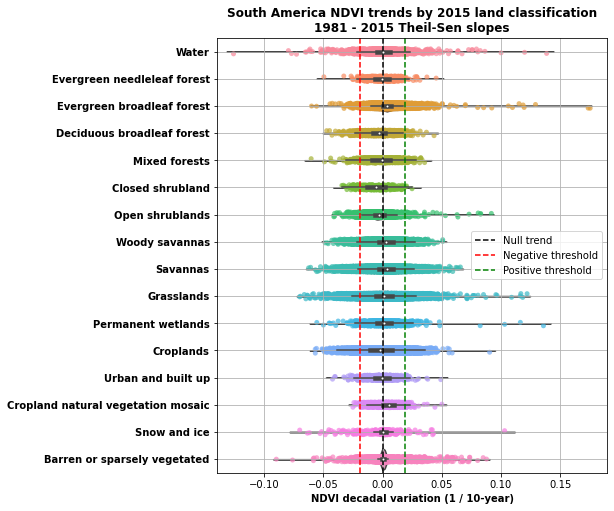

In [48]:
%%time

# Make figure.
plt.figure(figsize=(7, 8))

# Kernel density estimation.
plot1 = sns.violinplot(
    x="ndvi_slope",
    y="lclass_2015",
    data=df_matrix,
    orient="h"
)

# Data points.
plot2 = sns.stripplot(
    x="ndvi_slope",
    y="lclass_2015",
    data=df_matrix,
    orient="h",
    jitter=True,
    zorder=1,
    alpha=0.70,
    ax=plot1
)

# Adjustments.
plot2.set_yticklabels([classes_dict[key] for key in [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 
                                                     11, 12, 13, 14, 15, 16]], 
    weight="bold"
)
plot2.set_xlim((-0.14, 0.19))
plot2.grid()
plot2.axvline(ls="--", color="black", label="Null trend")
plot2.axvline(x=-u, ls="--", color="red", label="Negative threshold")
plot2.axvline(x=u, ls="--", color="green", label="Positive threshold")
plot2.set_xlabel("NDVI decadal variation (1 / 10-year)", weight="bold")
plot2.set_ylabel(None)
plot2.set_title("South America NDVI trends by 2015 land classification\n" + \
                "1981 - 2015 Theil-Sen slopes", weight="bold")
plot2.legend()

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_by_2015_land_class.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 14.5 s, sys: 92 ms, total: 14.6 s
Wall time: 14.7 s


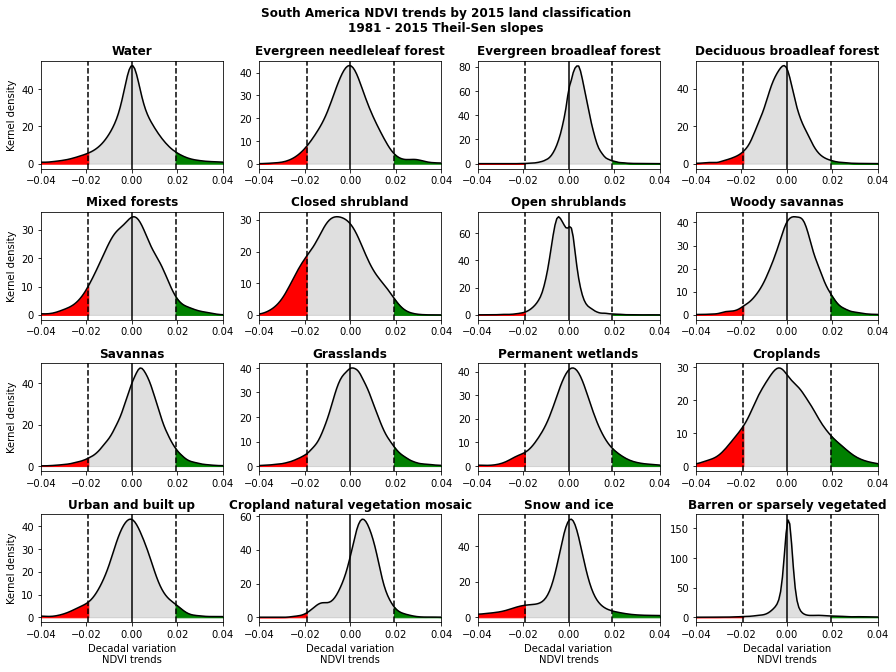

In [49]:
%%time

# Make figure.
fig, axes = plt.subplots(4, 4, figsize=(15, 10))
axes = axes.flatten()

# For KDE plots.
xx = np.linspace(-0.20, 0.20, 500)[:, np.newaxis]

# Loop over land classes.
for index, lclass_2015 in enumerate(
    np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])
):

    # Samples.
    data = df_matrix.ndvi_slope[df_matrix.lclass_2015==lclass_2015].values
    axes[index].set_xlim((-0.04, 0.04))
    
    # Vertical lines for thresholds of significance and for zero.
    axes[index].axvline(x=-u, ls="--", color="black")
    axes[index].axvline(x=u, ls="--", color="black")
    axes[index].axvline(x=0, ls="-", color="black")
    
    # Gaussian kernel density estimation.
    bandwidth = 1.06 * np.std(data) * (data.size ** (-1 / 5))
    kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(data[:, np.newaxis])
    yy = np.exp(kde.score_samples(xx))
    axes[index].plot(xx, yy, color="black")
    
    # Non-significan portion.
    xns = np.linspace(-u, u, 500)[:, np.newaxis]
    yns = np.exp(kde.score_samples(xns))
    axes[index].fill_between(x=xns.flatten(), y1=yns, y2=0, color="grey", alpha=0.25)

    # Significant portions.
    xs = np.linspace(u, 0.20, 500)[:, np.newaxis]
    ys = np.exp(kde.score_samples(xs))
    axes[index].fill_between(x=xs.flatten(), y1=ys, y2=0, color="green", alpha=1.0)
    xs = np.linspace(-0.20, -u, 500)[:, np.newaxis]
    ys = np.exp(kde.score_samples(xs))
    axes[index].fill_between(x=xs.flatten(), y1=ys, y2=0, color="red", alpha=1.0)
    
    # Adjustments.
    axes[index].set_title(classes_dict[lclass_2015], weight="bold")
                           
# More adjustments.
fig.suptitle("South America NDVI trends by 2015 land classification\n" + \
            "1981 - 2015 Theil-Sen slopes", weight="bold")
plt.subplots_adjust(hspace=0.40, top=0.905)
axes[12].set_xlabel("Decadal variation\nNDVI trends")
axes[13].set_xlabel("Decadal variation\nNDVI trends")
axes[14].set_xlabel("Decadal variation\nNDVI trends")
axes[15].set_xlabel("Decadal variation\nNDVI trends")
axes[0].set_ylabel("Kernel density")
axes[4].set_ylabel("Kernel density")
axes[8].set_ylabel("Kernel density")
axes[12].set_ylabel("Kernel density")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_by_2015_land_class_kdes.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 12.3 s, sys: 380 ms, total: 12.6 s
Wall time: 7.24 s


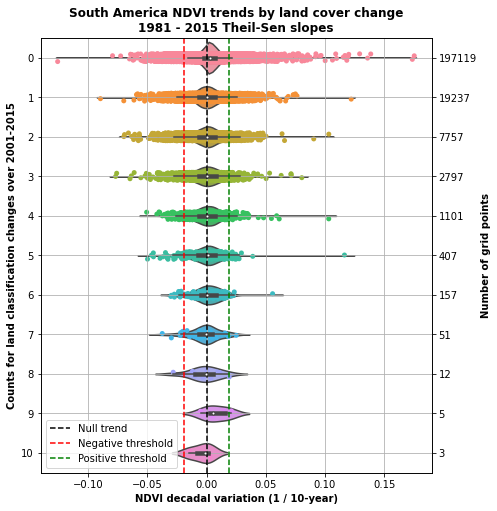

In [50]:
%%time

# Make figure.
plt.figure(figsize=(7, 8))

# Kernel density estimation.
plot1 = sns.violinplot(
    x="ndvi_slope",
    y="lclass_2001_2015_dcount",
    data=df_matrix,
    orient="h"
)

# Data points.
plot2 = sns.stripplot(
    x="ndvi_slope",
    y="lclass_2001_2015_dcount",
    data=df_matrix,
    orient="h",
    jitter=True,
    zorder=1,
    alpha=1.0,
    ax=plot1
)

# Adjustments.
plot2.set_xlim((-0.14, 0.19))
plot2.grid()
plot2.axvline(ls="--", color="black", label="Null trend")
plot2.axvline(x=-u, ls="--", color="red", label="Negative threshold")
plot2.axvline(x=u, ls="--", color="green", label="Positive threshold")
plot2.set_xlabel("NDVI decadal variation (1 / 10-year)", weight="bold")
plot2.set_ylabel("Counts for land classification changes over 2001-2015", weight="bold")
plot2.set_title("South America NDVI trends by land cover change\n" + \
                "1981 - 2015 Theil-Sen slopes", weight="bold")
plot2.legend()
ax2 = plot2.twinx()
ax2.set_ylim((10.5, -0.5))
ax2.set_yticks(np.arange(0, 11))
ax2.set_yticklabels(
    [str(c) for c in df_matrix.lclass_2001_2015_dcount.value_counts().values]
)
ax2.set_ylabel("Number of grid points", weight="bold")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_by_2001_2015_land_class_change.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

### By protection

In [51]:
df_matrix.protected_area.value_counts()

0    174029
1     54617
Name: protected_area, dtype: int64

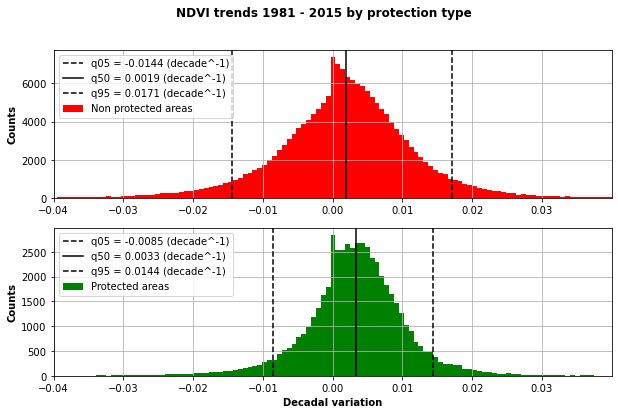

In [52]:

# Make figure.
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
bins = np.arange(-0.05, 0.05 + 0.0007, 0.0007)

# Histograms.
axes[0].hist(df_matrix.ndvi_slope[df_matrix.protected_area == int(0)], density=False,
             bins=bins, color="red", label="Non protected areas");
axes[1].hist(df_matrix.ndvi_slope[df_matrix.protected_area == int(1)], density=False,
             bins=bins, color="green", label="Protected areas")

# Quantiles.
q05, q50, q95 = np.quantile(df_matrix.ndvi_slope[df_matrix.protected_area == int(0)], 
                            q=[0.05, 0.50, 0.95])
axes[0].axvline(x=q05, ls="--", color="black", label=str("q05 = %.4f (decade^-1)" %(q05)))
axes[0].axvline(x=q50, ls="-", color="black", label=str("q50 = %.4f (decade^-1)" %(q50)))
axes[0].axvline(x=q95, ls="--", color="black", label=str("q95 = %.4f (decade^-1)" %(q95)))
q05, q50, q95 = np.quantile(df_matrix.ndvi_slope[df_matrix.protected_area == int(1)], 
                            q=[0.05, 0.50, 0.95])
axes[1].axvline(x=q05, ls="--", color="black", label=str("q05 = %.4f (decade^-1)" %(q05)))
axes[1].axvline(x=q50, ls="-", color="black", label=str("q50 = %.4f (decade^-1)" %(q50)))
axes[1].axvline(x=q95, ls="--", color="black", label=str("q95 = %.4f (decade^-1)" %(q95)))

# Adjustments.
fig.suptitle("NDVI trends 1981 - 2015 by protection type", weight="bold")
axes[0].legend(loc=2)
axes[1].legend(loc=2)
axes[0].set_xlim((-0.04, 0.04))
axes[1].set_xlim((-0.04, 0.04))
axes[1].set_xlabel("Decadal variation", weight="bold")
axes[0].set_ylabel("Counts", weight="bold")
axes[1].set_ylabel("Counts", weight="bold")
axes[0].set_xticks(np.arange(-0.04, 0.04, 0.01))
axes[1].set_xticks(np.arange(-0.04, 0.04, 0.01))
axes[0].grid()
axes[1].grid()

### Bi-histograms

CPU times: user 1.58 s, sys: 72 ms, total: 1.65 s
Wall time: 1.67 s


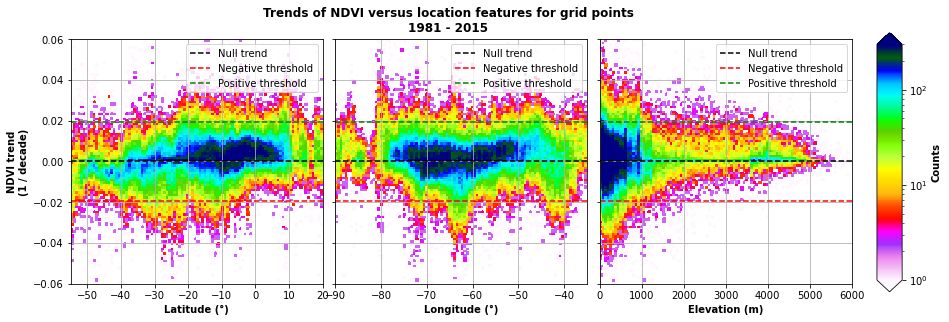

In [53]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Latitude.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.lat.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-55, 20), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Longitude.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.lon.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-90, -35), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Elevation.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.elev.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0, 6000), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Latitude (°)", weight="bold")
axes[1].set_xlabel("Longitude (°)", weight="bold")
axes[2].set_xlabel("Elevation (m)", weight="bold")
fig.suptitle("Trends of NDVI versus location features for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.46 s, sys: 40 ms, total: 1.5 s
Wall time: 1.5 s


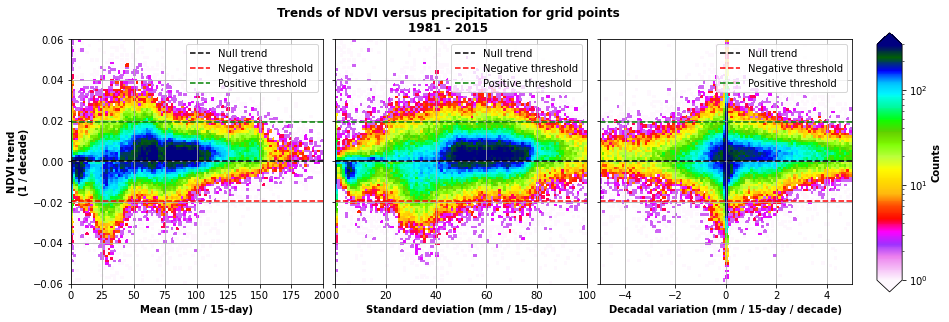

In [54]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Precipitation mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.p_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0, 200), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Precipitation deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.p_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0, 100), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Precipitaion slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.p_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-5, 5), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (mm / 15-day)", weight="bold")
axes[1].set_xlabel("Standard deviation (mm / 15-day)", weight="bold")
axes[2].set_xlabel("Decadal variation (mm / 15-day / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus precipitation for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.59 s, sys: 48 ms, total: 1.64 s
Wall time: 1.64 s


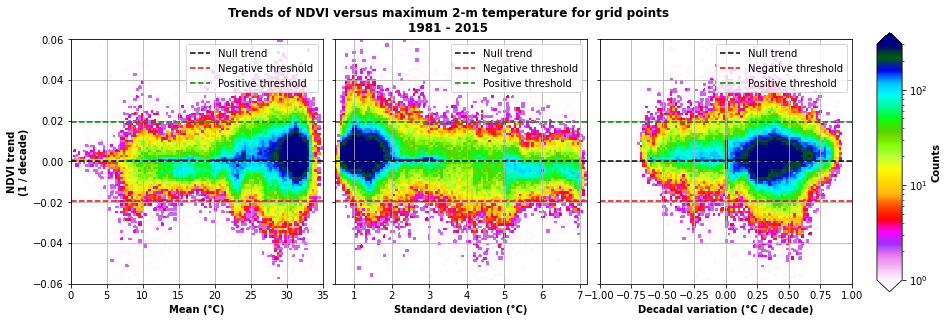

In [55]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Maximum 2-m temperature mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.tmax_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0, 35), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Maximum 2-m temperature deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.tmax_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0.5, 7.2), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Maximum 2-m temperature slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.tmax_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-1.00, 1.00), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (°C)", weight="bold")
axes[1].set_xlabel("Standard deviation (°C)", weight="bold")
axes[2].set_xlabel("Decadal variation (°C / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus maximum 2-m temperature for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms3.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.31 s, sys: 44 ms, total: 1.35 s
Wall time: 1.36 s


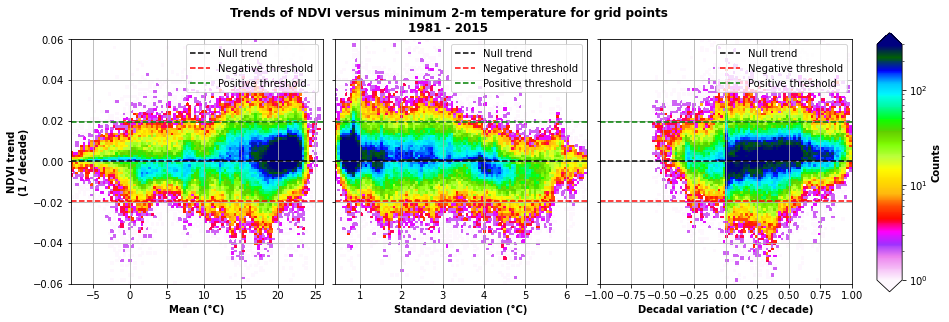

In [56]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Minimum 2-m temperature mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.tmin_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-8, 26), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Minimum 2-m temperature deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.tmin_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(0.4, 6.5), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Minimum 2-m temperature slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.tmin_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-1.00, 1.00), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (°C)", weight="bold")
axes[1].set_xlabel("Standard deviation (°C)", weight="bold")
axes[2].set_xlabel("Decadal variation (°C / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus minimum 2-m temperature for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms4.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.49 s, sys: 28 ms, total: 1.52 s
Wall time: 1.53 s


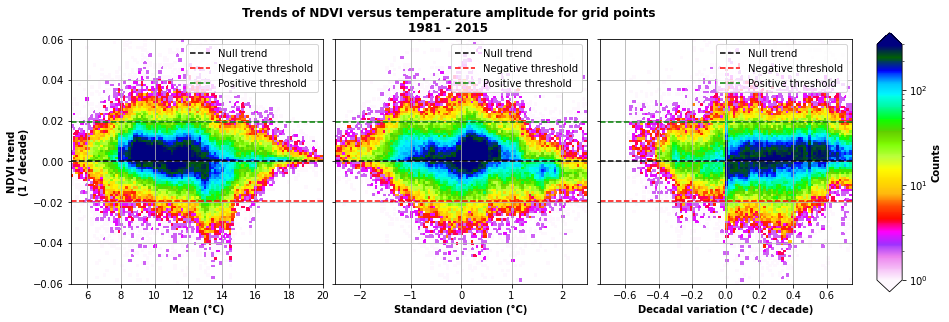

In [57]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Temperature amplitude mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.tmax_mean.values - df_matrix.tmin_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(5, 20), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Temperature amplitude deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.tmax_std.values - df_matrix.tmin_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-2.5, 2.5), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Temperature amplitude slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.tmin_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-0.75, 0.75), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (°C)", weight="bold")
axes[1].set_xlabel("Standard deviation (°C)", weight="bold")
axes[2].set_xlabel("Decadal variation (°C / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus temperature amplitude for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms5.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.32 s, sys: 40 ms, total: 1.36 s
Wall time: 1.37 s


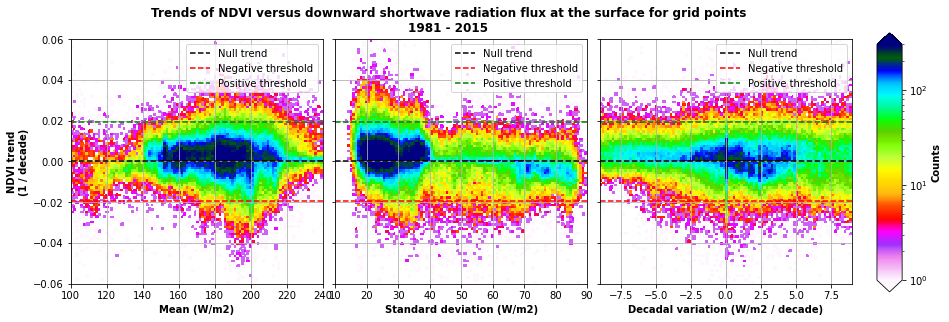

In [58]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# Radiation mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.srad_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(100, 240), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Radiation deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.srad_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(10, 90), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# Radiation slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.srad_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-9, 9), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (W/m2)", weight="bold")
axes[1].set_xlabel("Standard deviation (W/m2)", weight="bold")
axes[2].set_xlabel("Decadal variation (W/m2 / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus downward shortwave radiation flux at the surface for grid points" + \
             "\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms6.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 1.4 s, sys: 52 ms, total: 1.46 s
Wall time: 1.47 s


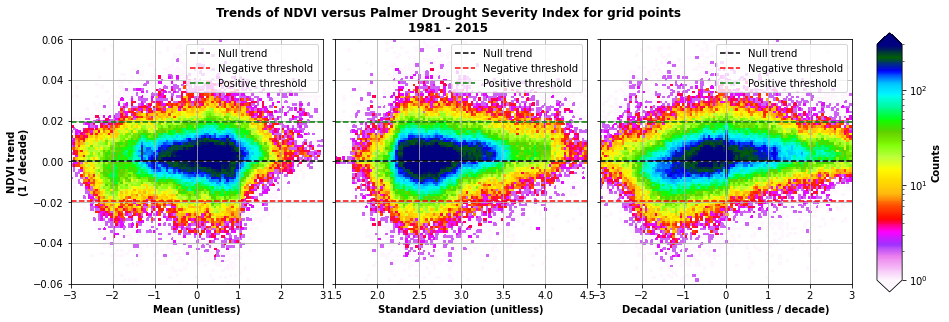

In [59]:
%%time

# Make figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 4.5), sharey=True)
axes = axes.flatten()

# PDSI mean.
_, _, _, image = axes[0].hist2d(
    x=df_matrix.pdsi_mean.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-3, 3), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# PDSI deviation.
_, _, _, image = axes[1].hist2d(
    x=df_matrix.pdsi_std.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(1.5, 4.5), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)  

# PDSI slope.
_, _, _, image = axes[2].hist2d(
    x=df_matrix.pdsi_slope.values,
    y=df_matrix.ndvi_slope.values,
    bins=(100, 100),
    range=[(-3, 3), (-0.06, 0.06)],
    cmap=plt.cm.gist_ncar_r,
    norm=mpl.colors.LogNorm(),
    vmin=1,
    vmax=300,
)   

# Commom color bar.
cbar_ax = fig.add_axes(rect=[0.925, 0.10, 0.025, 0.80])
cb = fig.colorbar(
    mappable=image, 
    cax=cbar_ax,
    extend="both",
    orientation="vertical",
)
cb.set_label("Counts", weight="bold")

# Horizontal lines.
for axis in axes:
    axis.axhline(ls="--", color="black", label="Null trend")
    axis.axhline(y=-u, ls="--", color="red", label="Negative threshold")
    axis.axhline(y=u, ls="--", color="green", label="Positive threshold")
    axis.legend()
    axis.grid()
    
# Adjustments.
axes[0].set_ylabel("NDVI trend\n(1 / decade)", weight="bold")
axes[0].set_xlabel("Mean (unitless)", weight="bold")
axes[1].set_xlabel("Standard deviation (unitless)", weight="bold")
axes[2].set_xlabel("Decadal variation (unitless / decade)", weight="bold")
fig.suptitle("Trends of NDVI versus Palmer Drought Severity Index for grid points\n1981 - 2015", weight="bold")
plt.subplots_adjust(wspace=0.05, hspace=0.35)

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_bihistograms7.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

### One hot encoding and scaling

In [60]:
%%time

# Numeric data (float and int). 
numeric_features = [
    "lclass_2001_2015_dcount",
    "lat", "lon", "elev", 
    "p_mean", "p_std", "p_slope",
    "tmax_mean", "tmax_std", "tmax_slope",
    "tmin_mean", "tmin_std", "tmin_slope", 
    "srad_mean", "srad_std", "srad_slope", 
    "pdsi_mean", "pdsi_std", "pdsi_slope", 
    "ndvi_mean", "ndvi_std"
]

# Categorical data.
categorical_features = ["lclass_2015", "protected_area", "biome"]

# Target.
target = ["ndvi_slope"]

# Inputs.
features = categorical_features + numeric_features

# One hot encoding.
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder())]
)

# Column-wise transformations by feature type.
one_hot_preprocessor = ColumnTransformer(
    transformers=[("categorical", categorical_transformer, categorical_features)],
    remainder="passthrough"
)

# Sequential applying of (1) one hot encoding and (2) scaling, 
preprocessing = Pipeline(
    steps=[
        ("one_hot_preprocessor", one_hot_preprocessor),
        ("scaler", RobustScaler())
    ]
)

# Data matrix of features as numpy array for input in machine learning models.
matrix_transformed = preprocessing.fit_transform(df_matrix[features])

print(">>> Matrix of features in final form (shape):", matrix_transformed.shape)

>>> Matrix of features in final form (shape): (228646, 51)
CPU times: user 408 ms, sys: 56 ms, total: 464 ms
Wall time: 464 ms


### Principal Component Analysis

In [61]:
%%time

# Do it.
pca = PCA(n_components=matrix_transformed.shape[1])
matrix_transformed2 = pca.fit_transform(X=matrix_transformed)

# Transform results from numpy array to pandas DataFrame object.
df_matrix_pca = pd.DataFrame(
    data=matrix_transformed2,
    columns=["PC" + str(i + 1) for i in range(matrix_transformed.shape[1])],
)

# Add location features.
df_matrix_pca.insert(loc=0, column="lat", value=df_matrix.lat)
df_matrix_pca.insert(loc=1, column="lon", value=df_matrix.lon)

# Multiindex.
df_matrix_pca.set_index(keys=["lat", "lon"], inplace=True)

# Now transform from pandas Dataframe to xarray Dataset object.
DS_PCA = df_matrix_pca.to_xarray()

# Show it.
print(DS_PCA)

<xarray.Dataset>
Dimensions:  (lat: 910, lon: 662)
Coordinates:
  * lat      (lat) float64 -55.88 -55.71 -55.62 -55.54 ... 19.79 19.88 19.96
  * lon      (lon) float64 -89.96 -89.88 -89.79 -89.71 ... -35.04 -34.96 -34.88
Data variables:
    PC1      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC2      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC3      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC4      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC5      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC6      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC7      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC8      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC9      (lat, lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    PC10     (lat, lon) float64 nan nan nan

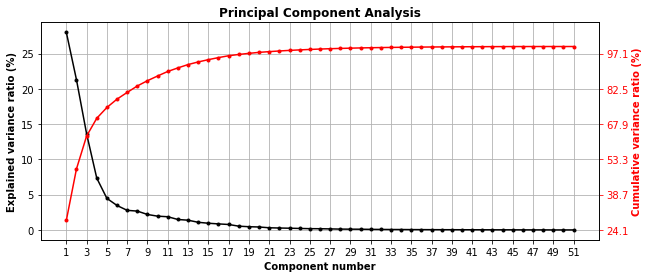

In [62]:
# Make figure.
plt.figure(figsize=(10, 4))
plt.plot(np.arange(1, matrix_transformed.shape[1] + 1), 
         pca.explained_variance_ratio_ * 100, ".-k")
plt.title("Principal Component Analysis", weight="bold")
plt.xlabel("Component number", weight="bold")
plt.ylabel("Explained variance ratio (%)", weight="bold")
plt.xticks(np.arange(1, matrix_transformed.shape[1] + 1)[::2])
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(np.arange(1, matrix_transformed.shape[1] + 1), 
         np.cumsum(pca.explained_variance_ratio_ * 100), ".-r")
ax2.set_ylabel("Cumulative variance ratio (%)", weight="bold")
ax2.yaxis.label.set_color("red")
ax2.tick_params(axis="y", colors="red")

# Align y axes.
ax2.set_ylim((20, 110))
l1 = ax1.get_ylim()
l2 = ax2.get_ylim()
f = lambda x : l2[0] + (x - l1[0]) / (l1[1] - l1[0]) * (l2[1] - l2[0])
ticks = f(ax1.get_yticks())
ax2.yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks))
ax1.grid()

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_pca.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

CPU times: user 9.58 s, sys: 100 ms, total: 9.68 s
Wall time: 9.72 s


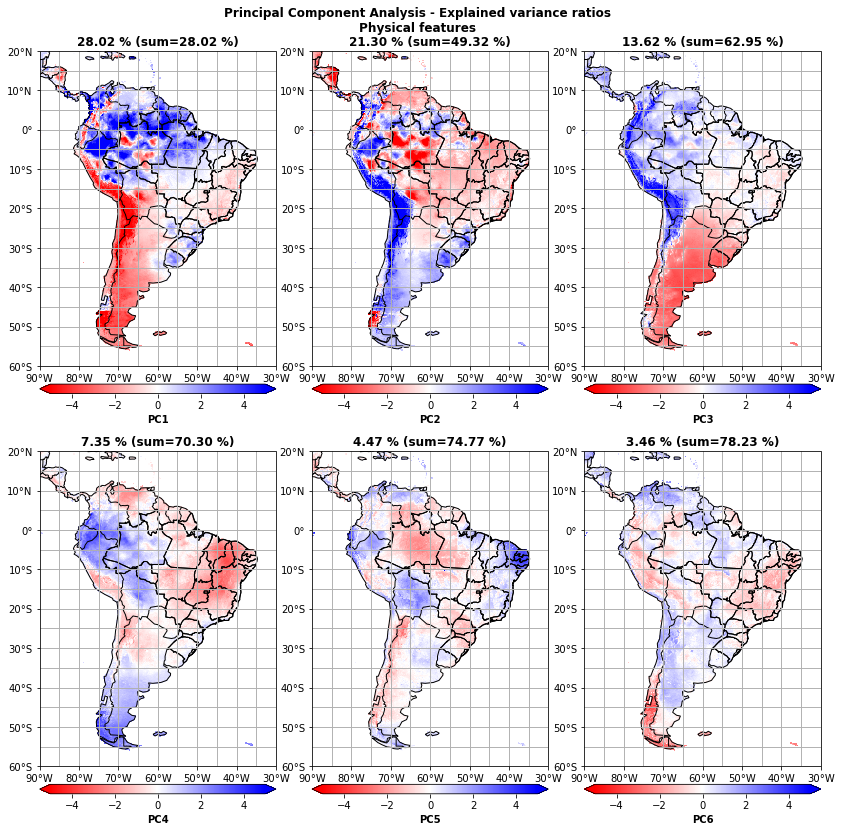

In [63]:
%%time

# Maps.
PCS = ["PC" + str(i) for i in range(1, 7)]
EXVARS = [
    str("%.2f %% (sum=%.2f %%)" %(i, j)) 
    for i, j in zip(
        (pca.explained_variance_ratio_ * 100)[:6], 
        np.cumsum(pca.explained_variance_ratio_ * 100)[:6]
    )]
axgr = cdlearn.maps.south_america(
    figsize=(14, 14), 
    nrows_ncols=(2, 3),
    suptitle=f"Principal Component Analysis - Explained variance ratios\nPhysical features",   
    suptitle_y=0.915,
    titles=EXVARS,
    cbar_mode="each",
    cbar_location="bottom"
)

# Plot them.
for index, axis in enumerate(axgr):
    
    # Map.
    plotmap = getattr(DS_PCA, PCS[index]).plot(
        ax=axis,
        cmap=plt.cm.bwr_r,
        vmin=-5,
        vmax=5,
        add_colorbar=False,
        add_labels=False
    )
    
    # Color bar.
    cb = plt.colorbar(
        plotmap, 
        cax=axgr.cbar_axes[index], 
        orientation="horizontal", 
        extend="both",
        pad=0.50
    )    
    cb.set_label(PCS[index], weight="bold")
    
# Adjustments.
axgr.set_axes_pad((0.50, 0.80))
    
# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_pca2.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

### Yeo-Johnson Transform

CPU times: user 28.8 s, sys: 116 ms, total: 28.9 s
Wall time: 29 s


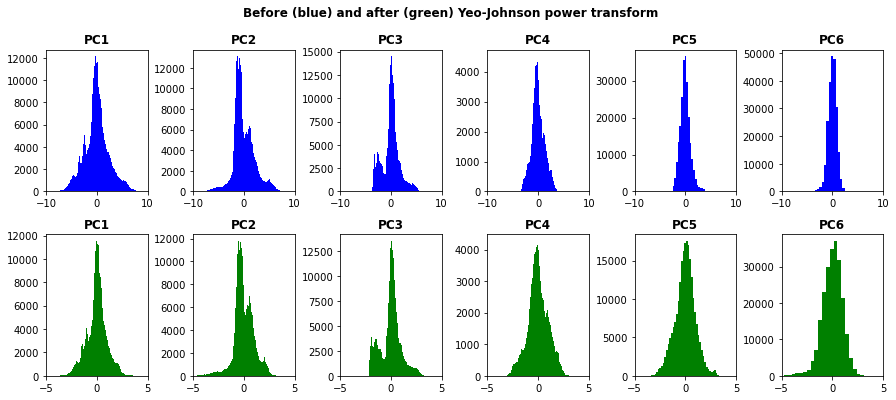

In [64]:
%%time

# Make figure.
fig, axes = plt.subplots(2, 6, figsize=(15, 6))

# Before transformation.
for index, axis in enumerate(axes[0, :]):
    key = "PC" + str(index + 1)
    axis.hist(getattr(df_matrix_pca, key).values, bins=200, color="blue")
    axis.set_xlim((-10, 10))
    axis.set_title(key, weight="bold")
    
# More Gaussian-like data.
matrix_transformed3 = PowerTransformer(
    method="yeo-johnson",
    standardize=True
).fit_transform(matrix_transformed2)

# Put in a pandas DataFrame object.
df_matrix_gaussian = pd.DataFrame(
    data=matrix_transformed3,
    columns=["PC" + str(i + 1) for i in range(matrix_transformed.shape[1])],
)

# After transformation.
for index, axis in enumerate(axes[1, :]):
    key = "PC" + str(index + 1)
    axis.hist(getattr(df_matrix_gaussian, key).values, bins=200, color="green")
    axis.set_xlim((-5, 5))
    axis.set_title(key, weight="bold")
    
# Adjustments.
plt.subplots_adjust(wspace=0.45, hspace=0.30)
fig.suptitle("Before (blue) and after (green) Yeo-Johnson power transform", weight="bold")

# Save figure.
if save_fig:
    plt.savefig(
        FIG_FOLDER + "ndvi_trends_power_transform.jpg", 
        dpi=200, 
        bbox_inches="tight"
    )

## Data split

In [65]:
# Simple train-test split as pandas DataFrame objects.
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(
    df_matrix[features], 
    df_matrix[target], 
    test_size=0.3, 
    stratify=df_matrix.lclass_2015
)

## Train a SVM model on raw data

In [66]:
%%time

# One hot encoding.
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder())]
)

# Column-wise transformations by feature type.
one_hot_preprocessor = ColumnTransformer(
    transformers=[("categorical", categorical_transformer, categorical_features)],
    remainder="passthrough"
)

# Append model to preprocessing pipeline. 
model_svm = Pipeline(
    steps=[
        ("one_hot_preprocessor", one_hot_preprocessor),
        ("model", SVR())
    ]
)

# Run fit with default set of hyper parameters.
_ = model_svm.fit(df_x_train, df_y_train)

CPU times: user 436 ms, sys: 36 ms, total: 472 ms
Wall time: 471 ms


CPU times: user 392 ms, sys: 32 ms, total: 424 ms
Wall time: 423 ms


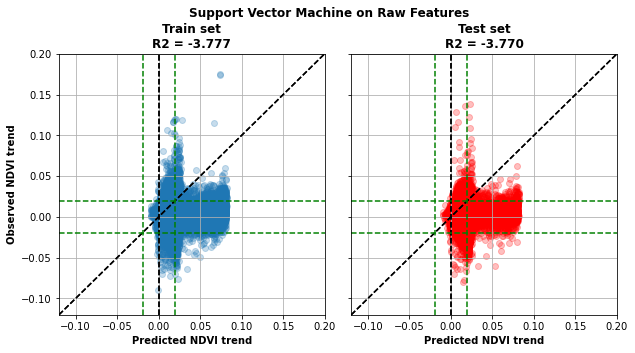

In [67]:
%%time

# Scatter plot of train and test scores.
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# Predictions.
df_y_train_pred = model_svm.predict(df_x_train)
df_y_test_pred = model_svm.predict(df_x_test)

# Train!
axes[0].scatter(df_y_train_pred, df_y_train, alpha=0.25)

# Test.
axes[1].scatter(df_y_test_pred, df_y_test, alpha=0.25, color="red")

# Diagonal, horizontal, and vertical lines.
for axis in axes:
    axis.set_ylim((-0.12, 0.20))
    axis.set_xlim((-0.12, 0.20))
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="black")
    axis.axvline(ls="--", color="black")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")

# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Support Vector Machine on Raw Features", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Train set\nR2 = %.3f" %(r2_score(df_y_train, df_y_train_pred)), 
                  weight="bold")
axes[1].set_title("Test set\nR2 = %.3f" %(r2_score(df_y_test, df_y_test_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
plt.subplots_adjust(top=0.85, wspace=0.10)

## Train a SVM model on preprocessed data

In [68]:
%%time

# One hot encoding.
categorical_transformer = Pipeline(
    steps=[("onehot", OneHotEncoder())]
)

# Column-wise transformations by feature type.
one_hot_preprocessor = ColumnTransformer(
    transformers=[("categorical", categorical_transformer, categorical_features)],
    remainder="passthrough"
)

# Append model to preprocessing pipeline. 
model_svm = Pipeline(
    steps=[
        ("one_hot_preprocessor", one_hot_preprocessor),
        ("robust_scaler", RobustScaler()),
        ("pca", PCA(n_components=20)),
        ("yeo_johnson", PowerTransformer(method="yeo-johnson",standardize=True)),
        ("model", SVR())
    ]
)

# Run fit with default set of hyper parameters.
_ = model_svm.fit(df_x_train, df_y_train)

CPU times: user 20.6 s, sys: 976 ms, total: 21.6 s
Wall time: 7.98 s


CPU times: user 7.77 s, sys: 328 ms, total: 8.1 s
Wall time: 947 ms


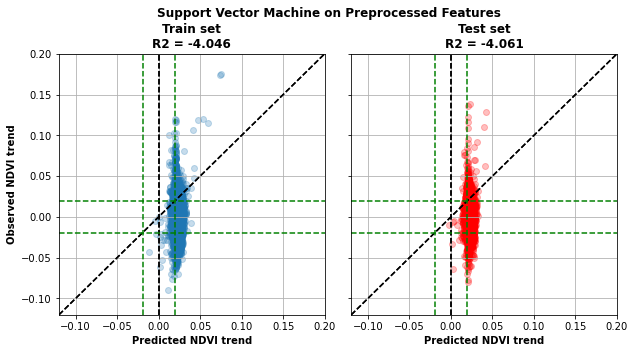

In [69]:
%%time

# Scatter plot of train and test scores.
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
axes = axes.flatten()

# Predictions.
df_y_train_pred = model_svm.predict(df_x_train)
df_y_test_pred = model_svm.predict(df_x_test)

# Train!
axes[0].scatter(df_y_train_pred, df_y_train, alpha=0.25)

# Test.
axes[1].scatter(df_y_test_pred, df_y_test, alpha=0.25, color="red")

# Diagonal, horizontal, and vertical lines.
for axis in axes:
    axis.set_ylim((-0.12, 0.20))
    axis.set_xlim((-0.12, 0.20))
    axis.plot(axes[0].get_xlim(), axes[0].get_xlim(), "--k")
    axis.axvline(ls="--", color="black")
    axis.axvline(ls="--", color="black")
    axis.plot(axis.get_xlim(), axis.get_xlim(), "--k")
    axis.axvline(x=-u, lw=1.5, ls="--", color="green")
    axis.axvline(x=u, lw=1.5, ls="--", color="green")
    axis.axhline(y=-u, lw=1.5, ls="--", color="green")
    axis.axhline(y=u, lw=1.5, ls="--", color="green")

# Adjustments.
axes[0].set_ylabel("Observed NDVI trend", weight="bold")
axes[0].set_xlabel("Predicted NDVI trend", weight="bold")
fig.suptitle("Support Vector Machine on Preprocessed Features", weight="bold")
axes[1].set_xlabel("Predicted NDVI trend", weight="bold")
axes[0].set_title("Train set\nR2 = %.3f" %(r2_score(df_y_train, df_y_train_pred)), 
                  weight="bold")
axes[1].set_title("Test set\nR2 = %.3f" %(r2_score(df_y_test, df_y_test_pred)), 
                  weight="bold")
axes[0].grid()
axes[1].grid()
plt.subplots_adjust(top=0.85, wspace=0.10)